In [1]:
%load_ext autoreload
%autoreload 2


In [7]:
from os import chdir

# change directory to the root of the project
chdir("../..")


# Libraries import


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import hw_predictor.utils as su


# Parameters


In [4]:
STATION_ID = 330020
INPUT_PATH = f"data/input/stations/{STATION_ID}"


# Code


In [9]:
data = pd.read_parquet(f"{INPUT_PATH}/daily_temp_history")

# normalize index and get only 'max_temp' non-null entries
max_temp = data.set_index(data.index.normalize()).dropna(subset=["max_temp"])[["max_temp"]]

max_temp


,max_temp
date,
1967-03-01,26.4
1967-03-02,27.8
1967-03-03,27.2
1967-03-04,27.8
1967-03-05,30.3
...,...
2023-10-28,15.6
2023-10-29,19.9
2023-10-30,19.7


## MeteoChile - Extreme threshold


### New Methodology

The **daily 90-percentile computation** is done through **HANTS**. Main idea is the following:

1. adjust a function that represents the series
2. compute `max_temp` columns according to the adjusted function
3. get the **90-percentile** from the simulated values given by the predicted values


In [16]:
from calendar import monthrange
from datetime import datetime

# get the number of days in each month for given year
#   - with this data we can compute the ext_threhold for each month/day in the year
year = 2020  # datetime.now().year
month_days = {"year": year, "month_days": {m: monthrange(year, m)[1] for m in range(1, 13)}}
start_date = datetime(year, 1, 1)
end_date = datetime(year, 12, 31)

month_days


{'year': 2020,
 'month_days': {1: 31,
  2: 29,
  3: 31,
  4: 30,
  5: 31,
  6: 30,
  7: 31,
  8: 31,
  9: 30,
  10: 31,
  11: 30,
  12: 31}}

/Users/msmendoza/local_documents/university/master/msc-project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/msmendoza/local_documents/university/master/msc-project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/msmendoza/local_documents/university/master/msc-project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/msmendoza/local_documents/university/master/msc-pr

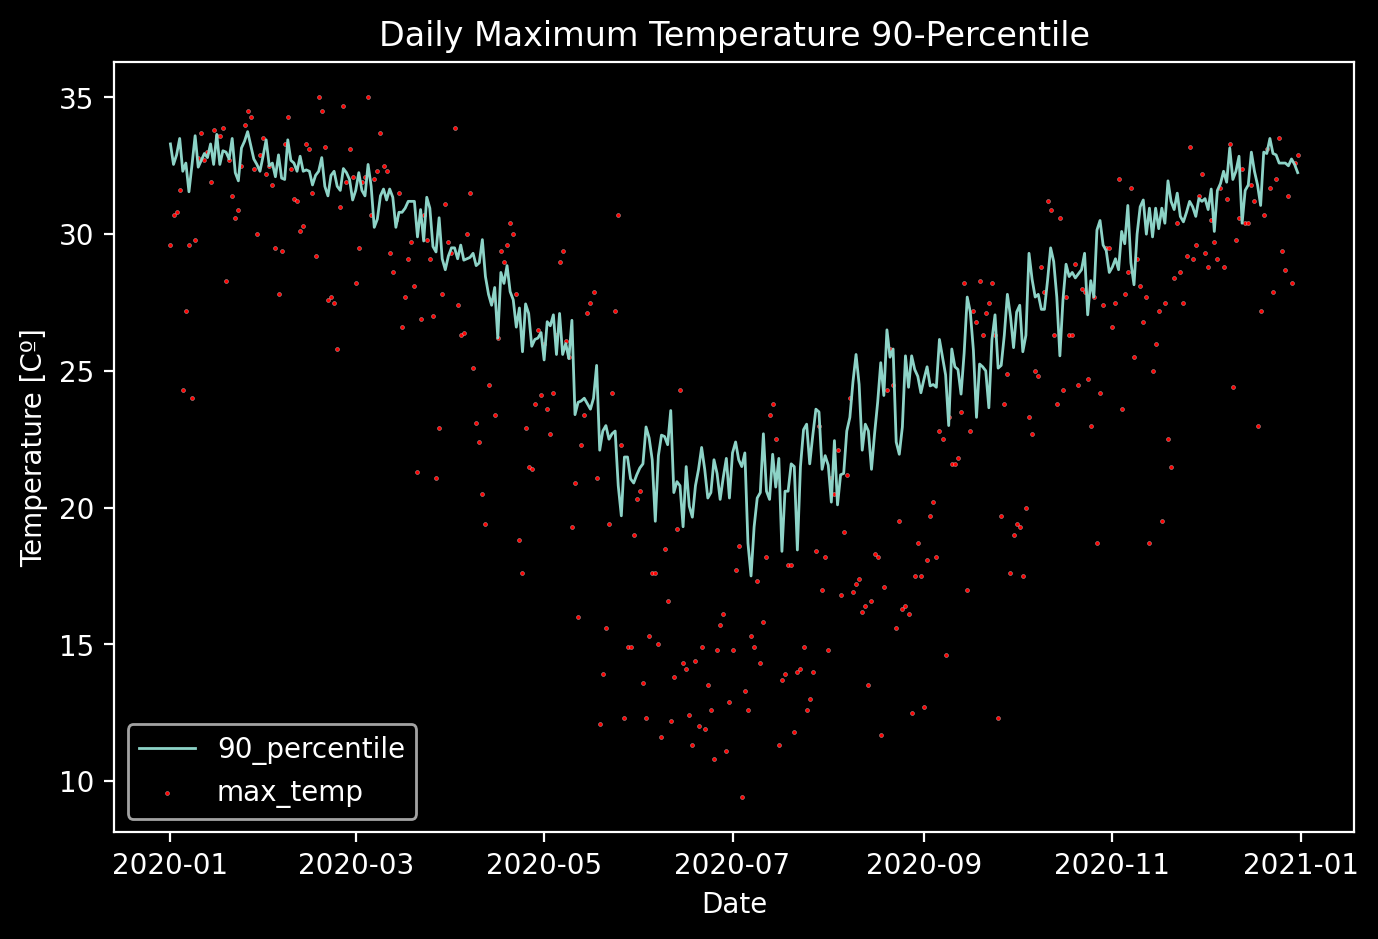

,max_temp,90_percentile
date,,
2020-01-01,29.6,33.3
2020-01-02,30.7,32.55
2020-01-03,30.8,32.9
2020-01-04,31.6,33.5
2020-01-05,24.3,32.3
...,...,...
2020-12-27,28.7,32.6
2020-12-28,31.4,32.5
2020-12-29,28.2,32.75


In [14]:
# compute the 90-percentile for each month/day in the year
max_temp_year = pd.DataFrame(
    [],
    columns=["max_temp", "90_percentile"],
    index=pd.Index(pd.date_range(start_date, end_date, freq="D"), name="date"),
)

# add entries from selected year
max_temp_year["max_temp"] = max_temp[max_temp.index.year == year]

for month in month_days["month_days"]:
    for day in range(1, month_days["month_days"][month] + 1):
        # the period used to compute the extreme threhold is 1981-2010 (Meteochile, 2020)
        # TODO: validate with scatter plot: 90-percentile vs max_temp (w/ different colors)
        f_max_temp = max_temp[
            (1981 <= max_temp.index.year)
            & (max_temp.index.year <= 2010)
            & (max_temp.index.day == day)
            & (max_temp.index.month == month)
        ]

        # TODO: update the following line with the 90_percentile from the HANTS adjusted data
        # * Discuss interpolation param with @elwin. It's clear it is not 'lower'|' higher'|'nearest'
        # * as the value is not in the data. But, what is the best option? 'midpoint' | 'linear'?
        max_temp_year.loc[datetime(year, month, day), "90_percentile"] = f_max_temp.quantile(
            0.9, interpolation="midpoint"
        ).values[0]

sns.lineplot(max_temp_year, y="90_percentile", x="date", label="90_percentile", lw=1)
sns.scatterplot(max_temp_year, y="max_temp", x="date", label="max_temp", color="red", s=2)

# plt.xlim([max_temp_2023.index.min(), datetime.now()])
# plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("Daily Maximum Temperature 90-Percentile")
plt.show()

max_temp_year


1. fit sin() in the above table.
2. feq = 0, this time we only consider constant Trend (a + bt -> a)


a + a1*cos(omega*x) ¿+ b1*sin(omega*x) 

a :  27.5  CI ~ N [2.73e+01,2.76e+01]
a1 :  5.78  CI ~ N [5.62e+00,5.95e+00]
b1 :  1.08  CI ~ N [9.17e-01,1.25e+00]

RSS model sine curve : 324.65


/Users/msmendoza/local_documents/university/master/msc-project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/msmendoza/local_documents/university/master/msc-project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/msmendoza/local_documents/university/master/msc-project/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/msmendoza/local_documents/university/master/msc-pr

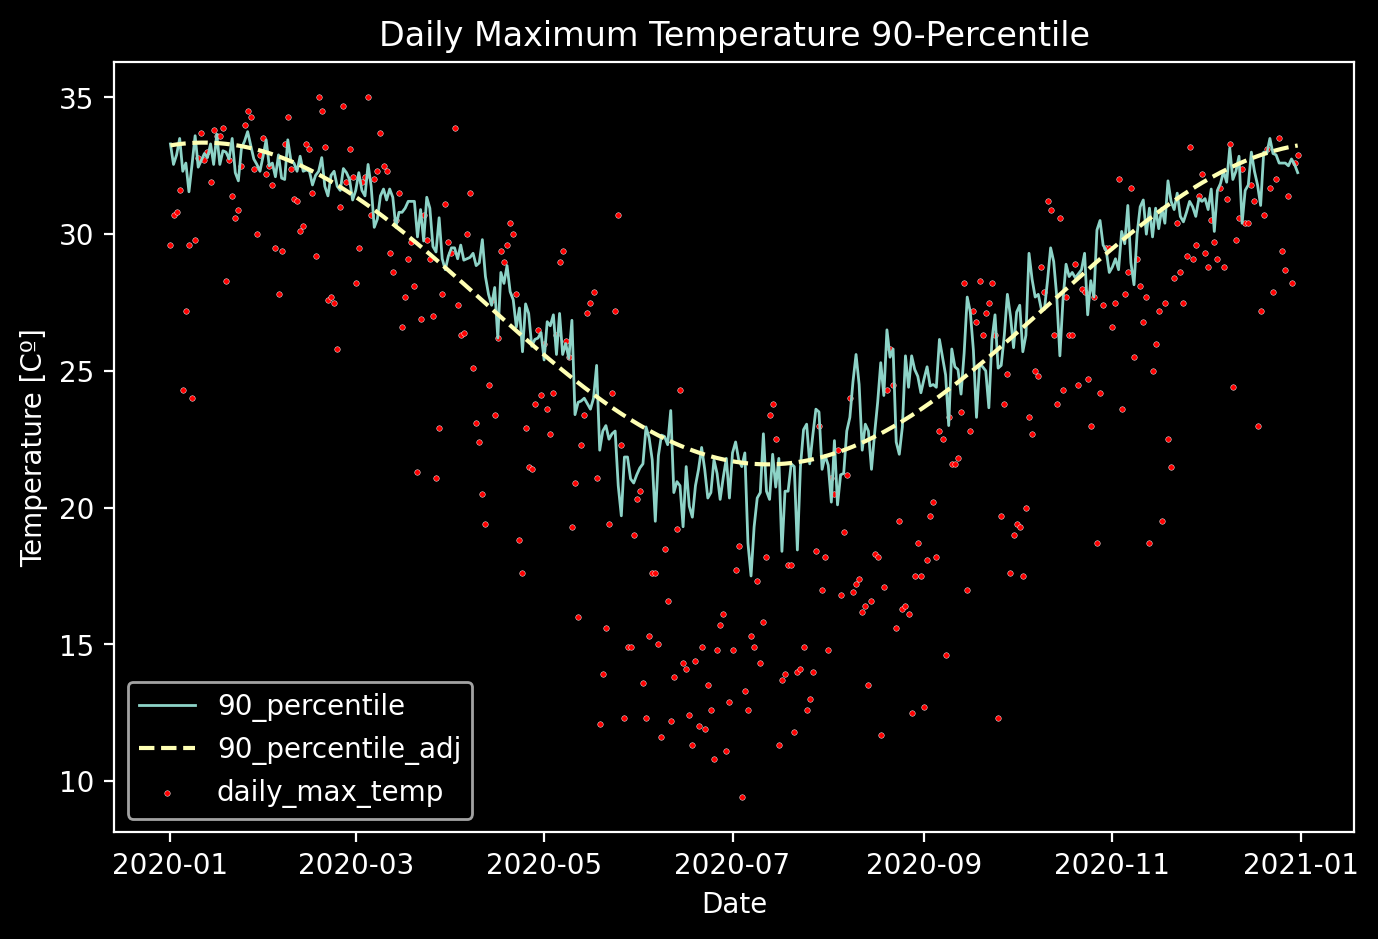

,max_temp,90_percentile,90_percentile_adj
date,,,
2020-01-01,29.6,33.3,33.247342
2020-01-02,30.7,32.55,33.265143
2020-01-03,30.8,32.9,33.281228
2020-01-04,31.6,33.5,33.295591
2020-01-05,24.3,32.3,33.308229
...,...,...,...
2020-12-27,28.7,32.6,33.152670
2020-12-28,31.4,32.5,33.177701
2020-12-29,28.2,32.75,33.201041


In [15]:
# TODO: improve fitting of function
# compute the 90-percentile for the given day
import datetime as dt
from scipy.stats import norm
from scipy.optimize import curve_fit


# new method
temp_t = max_temp_year["90_percentile"].copy(deep=True)
temp_t = temp_t.to_frame()


def model(x, params):
    a, a1, b1 = params
    omega = 2 * np.pi / 365.25  # 365.25
    theta = np.arctan(a1 / b1)
    alpha = np.sqrt(a1**2 + b1**2)

    y_pred = a + alpha * np.sin(omega * x + theta)
    return y_pred


def model_fit(x, a, a1, b1):
    omega = 2 * np.pi / 365.25
    y_pred = a + a1 * np.cos(omega * x) + b1 * np.sin(omega * x)
    return y_pred


def RSS(y, y_pred) -> float:
    return np.sqrt((y - y_pred) ** 2).sum()


if isinstance(temp_t.index, pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index = temp_t.index.map(dt.datetime.toordinal)


params, cov = curve_fit(
    model_fit, xdata=temp_t.index - first_ord, ydata=temp_t["90_percentile"], method="lm"
)
param_list = ["a", "a1", "b1"]
print("a + a1*cos(omega*x) ¿+ b1*sin(omega*x) \n")

std_dev = np.sqrt(np.diag(cov))
for name, p, sd in zip(param_list, params, std_dev):
    print(
        "{0} :  {1:0.3}  CI ~ N [{2:0.2e},{3:0.2e}]".format(name, p, p - 1.96 * sd, p + 1.96 * sd)
    )

max_temp_year.loc[:, "90_percentile_adj"] = model(temp_t.index - first_ord, params)
if isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index = temp_t.index.map(dt.datetime.toordinal)

print(
    "\nRSS model sine curve :",
    round(
        RSS(
            max_temp_year["90_percentile"].astype(float),
            max_temp_year["90_percentile_adj"].astype(float),
        ),
        2,
    ),
)

sns.lineplot(max_temp_year, y="90_percentile", x="date", label="90_percentile", lw=1)
sns.lineplot(
    max_temp_year, y="90_percentile_adj", x="date", label="90_percentile_adj", lw=1.5, ls="--"
)
sns.scatterplot(max_temp_year, y="max_temp", x="date", label="daily_max_temp", color="red", s=4)

# plt.xlim([max_temp_2023.index.min(), datetime.now()])
# plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("Daily Maximum Temperature 90-Percentile")
plt.show()

max_temp_year


In [10]:
# get threholds from Meteochile for the station of interest
thresholds_meteochile = su.html_table_to_xlsx(
    f"https://climatologia.meteochile.gob.cl/application/historico/umbralesOlasDeCalorEstacion/{STATION_ID}",
    "excel",  # this can be checked out on the source code of the page
    f"{INPUT_PATH}/thresholds.xlsx",
)
thresholds_meteochile


month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
day,,,,,,,,,,,,
1,32.5,33.0,32.1,29.4,25.7,22.3,20.9,21.9,24.4,27.2,29.5,31.2
2,32.5,33.0,32.0,29.3,25.5,22.2,20.9,21.9,24.5,27.2,29.6,31.3
3,32.6,33.0,32.0,29.1,25.4,22.1,20.9,22.0,24.6,27.3,29.6,31.3
4,32.6,32.9,31.9,29.0,25.3,22.1,20.9,22.1,24.7,27.4,29.7,31.4
5,32.6,32.9,31.8,28.9,25.2,22.0,20.9,22.1,24.8,27.5,29.8,31.4
6,32.7,32.9,31.8,28.8,25.0,21.9,20.9,22.2,24.9,27.6,29.8,31.5
7,32.7,32.9,31.7,28.7,24.9,21.8,20.9,22.3,25.0,27.7,29.9,31.5
8,32.7,32.9,31.6,28.6,24.8,21.8,20.9,22.3,25.1,27.7,30.0,31.6
9,32.7,32.9,31.5,28.4,24.7,21.7,20.9,22.4,25.1,27.8,30.0,31.6


In [11]:
# First, reset the index to move day into a column
df = thresholds_meteochile.reset_index()

# Then use `melt` to reverse the pivot
df_melted = df.melt(id_vars="day", var_name="month", value_name="90_percentile_meteochile")

# Convert month name back to number
months_mapper = {f"{i:02d}": dt.date(1900, i, 1).strftime("%b") for i in range(1, 13)}
r_months_mapper = {v: k for k, v in months_mapper.items()}  # reverse the mapper
df_melted["month"] = df_melted["month"].map(r_months_mapper)

# Convert day and month to integer for proper sorting
df_melted["month"] = df_melted["month"].astype(int)
df_melted["day"] = df_melted["day"].astype(int)

# Sort by month and day
df_melted.sort_values(by=["month", "day"], inplace=True)

# If you want to reset the index
df_melted = df_melted.dropna().reset_index(drop=True)

# remove 2023-02-29
df_melted = df_melted[~((df_melted.month == 2) & (df_melted.day == 29))]

# datetime index for current year from day and month columns
df_melted["date"] = df_melted[["month", "day"]].apply(
    lambda x: dt.date(2023, x.month, x.day), axis=1
)
df_melted.drop(columns=["month", "day"], inplace=True)
df_melted.set_index("date", inplace=True, drop=True)

df_melted


,90_percentile_meteochile
date,
2023-01-01,32.5
2023-01-02,32.5
2023-01-03,32.6
2023-01-04,32.6
2023-01-05,32.6
...,...
2023-12-27,32.4
2023-12-28,32.4
2023-12-29,32.4


In [12]:
# reproduce MeteoChile 'Umbrales Olas de Calor (Diurna)' report to check whether the HANTS
# algorithm is working as expected regarding the defintion of the 90-percentile
ans = max_temp_year[["90_percentile_adj"]].copy(deep=True)

ans["month"] = ans.index.strftime("%m")
ans["day"] = ans.index.strftime("%d")

thresholds_pivot = ans.pivot(index="day", columns="month", values="90_percentile_adj").rename(
    columns=months_mapper
)
thresholds_pivot.index = thresholds_pivot.index.astype(int)
thresholds_pivot = thresholds_pivot.round(1)

thresholds_pivot


month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
day,,,,,,,,,,,,
1,33.3,33.0,31.4,28.6,25.6,23.0,21.7,21.9,23.7,26.4,29.5,32.0
2,33.3,32.9,31.3,28.5,25.5,22.9,21.7,21.9,23.7,26.5,29.6,32.0
3,33.3,32.9,31.2,28.4,25.4,22.9,21.7,22.0,23.8,26.6,29.7,32.1
4,33.3,32.9,31.1,28.3,25.3,22.8,21.6,22.0,23.9,26.7,29.8,32.1
5,33.3,32.8,31.1,28.2,25.2,22.8,21.6,22.1,24.0,26.8,29.9,32.2
6,33.3,32.8,31.0,28.1,25.1,22.7,21.6,22.1,24.1,26.9,29.9,32.3
7,33.3,32.7,30.9,28.0,25.0,22.6,21.6,22.1,24.2,27.0,30.0,32.3
8,33.4,32.7,30.8,27.9,24.9,22.6,21.6,22.2,24.2,27.1,30.1,32.4
9,33.4,32.6,30.7,27.8,24.8,22.5,21.6,22.2,24.3,27.2,30.2,32.4


In [13]:
# add the 90-percentile from MeteoChile to the dataframe
max_temp_year = max_temp_year.join(df_melted)

# create binary column with 1 if the max_temp is above the (personal) threshold
max_temp_year.loc[:, "above_threshold"] = (
    max_temp_year["90_percentile_adj"] < max_temp_year["max_temp"]
).astype(int)

temps_above_threshold = max_temp_year[max_temp_year["above_threshold"] == 1].copy(deep=True)

# create dataframe with heatwaves information (start, end, duration, mean_temp, max_temp, date)
heatwaves = pd.DataFrame(
    columns=["start", "end", "duration", "mean_temp", "min_temp", "max_temp", "date"]
)

# get start and end of continuous heatwaves
heatwaves_dates = []  # [(start, end), (start, end), ...]
for i in range(1, len(temps_above_threshold)):
    # continuous heatwaves
    if temps_above_threshold.index[i] - temps_above_threshold.index[i - 1] == dt.timedelta(days=1):
        # if empty, add first heatwave
        if len(heatwaves_dates) == 0:
            heatwaves_dates.append(
                (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
            )
        # if not empty, check if the last heatwave is continuous
        else:
            # if continuous, update end date
            if heatwaves_dates[-1][1] == temps_above_threshold.index[i - 1]:
                heatwaves_dates[-1] = (heatwaves_dates[-1][0], temps_above_threshold.index[i])
            # if not continuous, add new heatwave
            else:
                heatwaves_dates.append(
                    (temps_above_threshold.index[i - 1], temps_above_threshold.index[i])
                )

for idx, hw_dates in enumerate(heatwaves_dates):
    # get start and end dates
    start = hw_dates[0]
    end = hw_dates[1]

    # get duration
    duration = (end - start).days + 1

    # get mean and max temp
    mean_temp = max_temp_year.loc[start:end, "max_temp"].mean()
    min_temp = max_temp_year.loc[start:end, "max_temp"].min()
    max_temp = max_temp_year.loc[start:end, "max_temp"].max()

    # get max_temp date
    date = max_temp_year.loc[start:end, "max_temp"].idxmax()

    # add to dataframe
    heatwaves.loc[idx] = [start, end, duration, mean_temp, min_temp, max_temp, date]

# filter heatwaves with duration >= 3 days
heatwaves = (
    heatwaves[heatwaves["duration"] >= 3]
    .sort_values(by="start", ascending=False)
    .reset_index(drop=True)
)

heatwaves


,start,end,duration,mean_temp,min_temp,max_temp,date
0,2023-05-08,2023-05-14,7,27.828571,26.8,29.0,2023-05-09
1,2023-04-06,2023-04-11,6,30.233333,28.5,32.5,2023-04-07
2,2023-03-30,2023-04-02,4,31.700000,30.3,33.4,2023-03-31
3,2023-03-21,2023-03-26,6,32.416667,29.3,33.9,2023-03-24
4,2023-02-26,2023-03-02,5,33.680000,32.5,34.8,2023-02-27
5,2023-02-19,2023-02-21,3,33.633333,33.0,34.6,2023-02-20
6,2023-02-08,2023-02-11,4,34.375000,32.9,35.8,2023-02-09


In [14]:
# TODO: automate over years
yearly_hw_stats = pd.DataFrame(
    [],
    index=pd.Index([], name="year", dtype=int),
    columns=[
        "n_hw",
        "mean_hw_temp",
        "max_hw_temp",
        "min_hw_temp",
        "mean_hw_duration",
        "max_hw_duration",
        "min_hw_duration",
    ],
)

yearly_hw_stats.loc[2023, "n_hw"] = len(heatwaves)
yearly_hw_stats.loc[2023, "mean_hw_temp"] = heatwaves["mean_temp"].mean()
yearly_hw_stats.loc[2023, "max_hw_temp"] = heatwaves["max_temp"].max()
yearly_hw_stats.loc[2023, "min_hw_temp"] = heatwaves["min_temp"].min()
yearly_hw_stats.loc[2023, "mean_hw_duration"] = heatwaves["duration"].mean()
yearly_hw_stats.loc[2023, "max_hw_duration"] = heatwaves["duration"].max()
yearly_hw_stats.loc[2023, "min_hw_duration"] = heatwaves["duration"].min()

yearly_hw_stats


,n_hw,mean_hw_temp,max_hw_temp,min_hw_temp,mean_hw_duration,max_hw_duration,min_hw_duration
year,,,,,,,
2023,7,31.980986,35.8,26.8,5.0,7,3


In [15]:
# TODO: per station historic stats


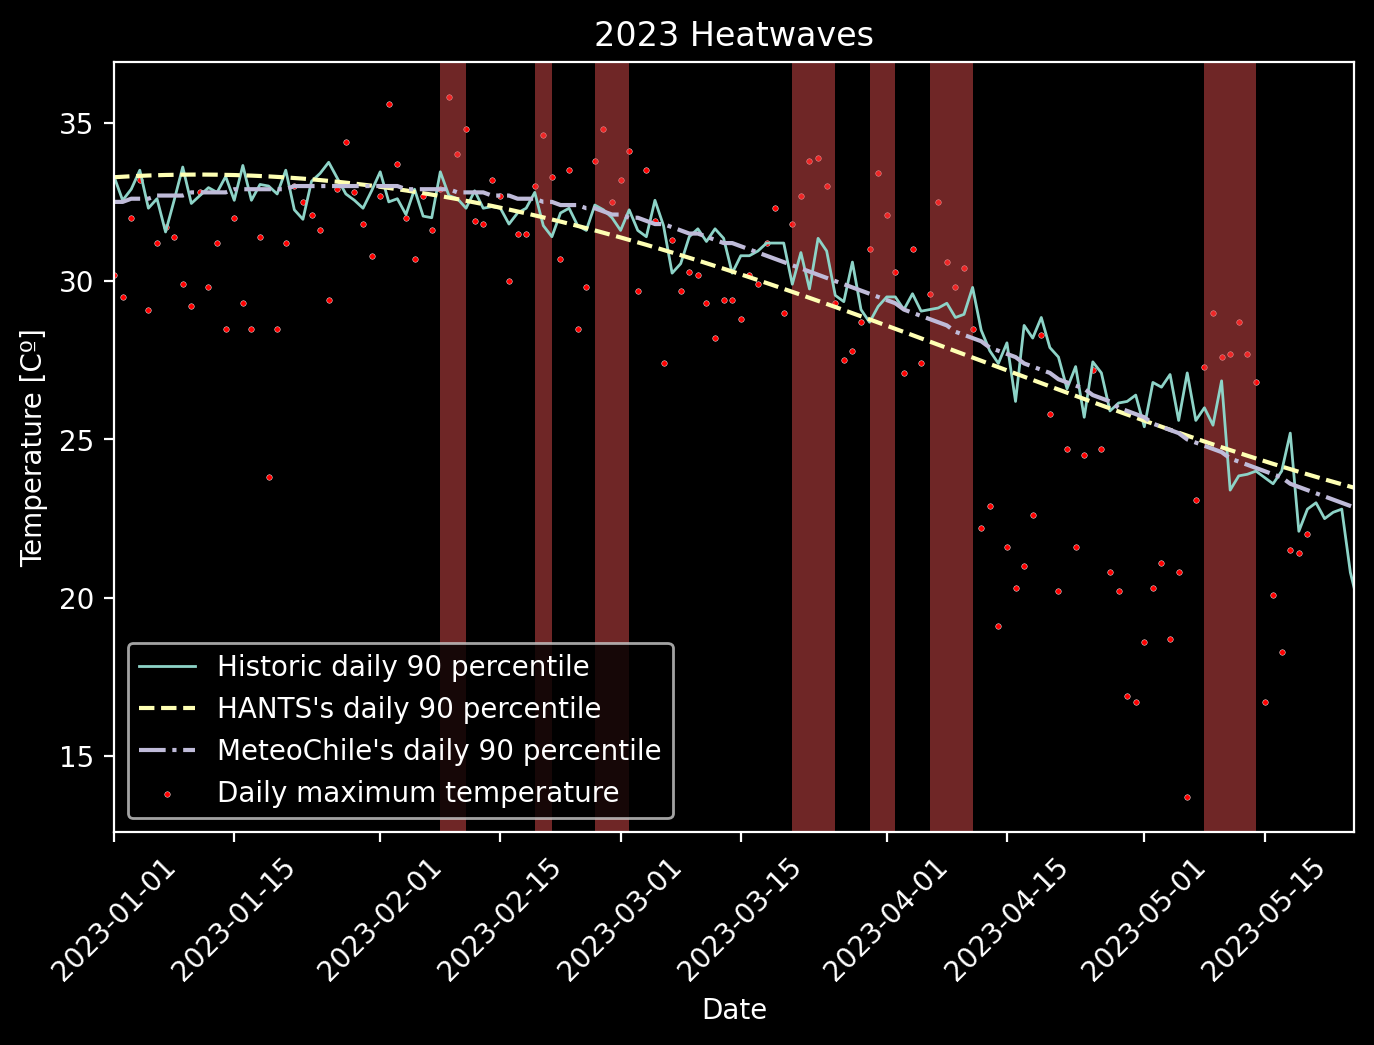

In [16]:
sns.lineplot(
    max_temp_year,
    y="90_percentile",
    x="date",
    label="Historic daily 90 percentile",
    lw=1,
)
sns.lineplot(
    max_temp_year,
    y="90_percentile_adj",
    x="date",
    label="HANTS's daily 90 percentile",
    lw=1.5,
    ls="--",
)
sns.lineplot(
    max_temp_year,
    y="90_percentile_meteochile",
    x="date",
    label="MeteoChile's daily 90 percentile",
    lw=1.5,
    ls="-.",
)
sns.scatterplot(
    max_temp_year,
    y="max_temp",
    x="date",
    label="Daily maximum temperature",
    color="red",
    s=4,
)

# vertical span for heatwaves
heatwaves_dates = heatwaves[["start", "end"]].values
for hw_dates in heatwaves_dates:
    plt.axvspan(hw_dates[0], hw_dates[1], facecolor="#DE4D4D", alpha=0.5)

plt.xlim([max_temp_year.index.min(), datetime.now()])
plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Temperature [Cº]")
plt.title("2023 Heatwaves")
plt.show()
